In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=725ef3c055ae4bfaac56b7274674e9400329a61c402525c75fb0a28d6caaa950
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# all outputs of the cell diff lines not just last

In [5]:
#Necessary Libraries


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, StringType, FloatType, DoubleType
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from pyspark.sql.functions import col
from pyspark.sql.functions import expr


from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report
from pyspark.sql.functions import split, col, regexp_extract, expr, count, when, asc, year, quarter, month, weekofyear, hour, day

# mlib
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, VectorAssembler







spark = SparkSession.builder.master("local").appName("classification").getOrCreate()

In [6]:
#Uploading data
schema = StructType([
    StructField('user_session', StringType(), True),
    StructField('category_code', StringType(), True),
    StructField('product_id', IntegerType(), True),
    StructField('user_id', IntegerType(), True),
    StructField('price', FloatType(), True),
    StructField('AddedToCart', IntegerType(), True),
    StructField('eventDay', IntegerType(), True),
    StructField('count_view', IntegerType(), True),
    StructField('timeSpent_sec', IntegerType(), True),
    StructField('isPurchased', IntegerType(), True),
    StructField('multiChoice', IntegerType(),True),
    StructField('PurBefore', IntegerType(),True)
])
df = spark.read.csv('/content/df_clf_new_corr.csv', schema = schema, header = True)

# EDA

In [ ]:
df.show(10, 0)
print(f'Shape of dataset: ({df.count()}, {len(df.columns)})')

+------------------------------------+-------------+----------+---------+------+-----------+--------+----------+-------------+-----------+-----------+---------+
|user_session                        |category_code|product_id|user_id  |price |AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|
+------------------------------------+-------------+----------+---------+------+-----------+--------+----------+-------------+-----------+-----------+---------+
|0039f13c-a89f-4955-8023-2b6bcca43ee7|sport        |4804056   |588826226|169.61|1          |17      |1         |97           |1          |0          |0        |
|0057614f-8536-4961-805c-7d45be312a71|electronics  |100003485 |552867230|180.18|0          |28      |1         |0            |0          |1          |0        |
|00c3bf9d-2ad4-4cc3-9e7b-e618ff0b5d68|construction |1003319   |513785612|900.64|1          |7       |1         |21           |1          |0          |0        |
|01453a19-68fa-4c1e-98a8-3b9e5849b

## EDA on Shopers who did at least 1 purchase:

In [ ]:
purchased_users_count = df.filter(df["isPurchased"] == 1).select("user_id").distinct().count()
average_time_spent = df.filter(df["isPurchased"] == 1).agg({"timeSpent_sec": "avg"}).first()[0]
most_purchased_category = df.filter(df["isPurchased"] == 1).groupBy("category_code").count().orderBy("count", ascending=False).first()["category_code"]
average_time_spent = df.filter(df["isPurchased"] == 1).agg({"timeSpent_sec": "avg"}).first()[0]
average_purchase_price = df.filter(df["isPurchased"] == 1).agg({"price": "avg"}).first()[0]
purchase_sessions_count = df.filter(df["isPurchased"] == 1).select("user_session").distinct().count()


print(f"- Number of distinct users who made at least one purchase: {purchased_users_count}\n"
      f"- Average time spent for users who made a purchase: {average_time_spent:.2f} seconds\n"
      f"- The category with the highest number of purchases: {most_purchased_category}\n"
      f"- Average price of products purchased: ${average_purchase_price:.2f}\n"
      f"- Number of distinct sessions that resulted in a purchase: {purchase_sessions_count}")


- Number of distinct users who made at least one purchase: 39704
- Average time spent for users who made a purchase: 315.49 seconds
- The category with the highest number of purchases: construction
- Average price of products purchased: $349.54
- Number of distinct sessions that resulted in a purchase: 104837


In [ ]:
views_distribution = df.filter(df["isPurchased"] == 1).groupBy("count_view").count().orderBy("count_view").show()


+----------+-----+
|count_view|count|
+----------+-----+
|         1|78596|
|         2|20569|
|         3| 9835|
|         4| 5134|
|         5| 3001|
|         6| 1801|
|         7| 1162|
|         8|  739|
|         9|  495|
|        10|  353|
|        11|  235|
|        12|  176|
|        13|  111|
|        14|   86|
|        15|   65|
|        16|   46|
|        17|   22|
|        18|   30|
|        19|   15|
|        20|   11|
+----------+-----+
only showing top 20 rows



In [ ]:
multiple_purchases_users = df.filter(df["isPurchased"] == 1) \
    .groupBy("user_id", "user_session") \
    .agg({"isPurchased": "count"}) \
    .filter("count(isPurchased) > 1") \
    .groupBy("user_id") \
    .agg({"user_session": "count", "count(isPurchased)": "sum"}) \
    .withColumnRenamed("count(user_session)", "num_sessions") \
    .withColumnRenamed("sum(count(isPurchased))", "total_purchases")

multiple_purchases_users.show(25, 0)
# Total count 6k..

+---------+------------+---------------+
|user_id  |num_sessions|total_purchases|
+---------+------------+---------------+
|620223775|4           |8              |
|625158526|2           |4              |
|600648805|1           |2              |
|626887517|1           |2              |
|592244706|3           |10             |
|628266828|1           |2              |
|620230352|4           |9              |
|626363273|1           |2              |
|626259279|1           |2              |
|585643355|4           |10             |
|599147352|1           |2              |
|634666635|1           |2              |
|590391609|2           |4              |
|624071135|2           |5              |
|596632014|3           |6              |
|612145115|3           |10             |
|517741149|1           |2              |
|633767687|3           |11             |
|542148983|1           |2              |
|623176739|1           |2              |
|626706975|2           |4              |
|520773168|1    

<Figure size 1200x600 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'furniture'),
  Text(1, 0, 'appliances'),
  Text(2, 0, 'electronics'),
  Text(3, 0, 'accessories'),
  Text(4, 0, 'computers'),
  Text(5, 0, 'apparel'),
  Text(6, 0, 'kids'),
  Text(7, 0, 'stationery'),
  Text(8, 0, 'auto'),
  Text(9, 0, 'country_yard'),
  Text(10, 0, 'construction'),
  Text(11, 0, 'sport'),
  Text(12, 0, 'medicine')])

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Average time spent in seconds')

Text(0.5, 1.0, 'Average time spent per Category for purchased items')

Text(0, 10, '491.57')

Text(0, 10, '454.35')

Text(0, 10, '401.55')

Text(0, 10, '376.53')

Text(0, 10, '365.35')

Text(0, 10, '339.14')

Text(0, 10, '328.75')

Text(0, 10, '324.86')

Text(0, 10, '282.23')

Text(0, 10, '281.34')

Text(0, 10, '258.70')

Text(0, 10, '239.16')

Text(0, 10, '219.89')

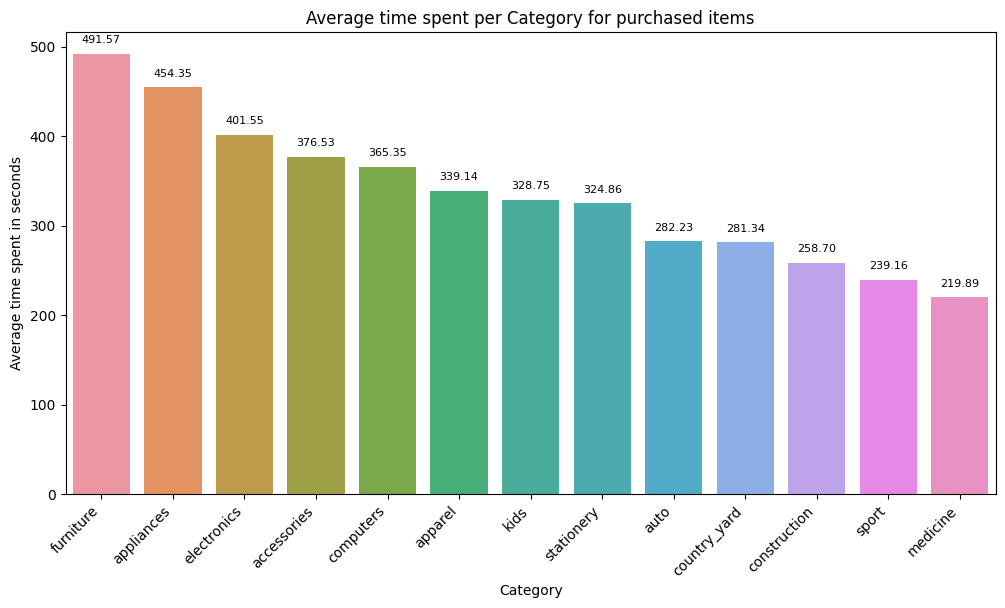

In [ ]:
avg_t_cat = df.filter(df["isPurchased"] == 1).groupBy("category_code").agg({"timeSpent_sec": "avg"}).toPandas()
avg_t_cat = avg_t_cat.sort_values(by="avg(timeSpent_sec)", ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="category_code", y="avg(timeSpent_sec)", data=avg_t_cat)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Average time spent in seconds")
plt.title("Average time spent per Category for purchased items")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()


## EDA on Shopers who viewed/added to cart but haven't purchased

In [ ]:
popular_categories_cart_not_purchased = df.filter((df["AddedToCart"] == 1) & (df["isPurchased"] == 0)).groupBy("category_code").count().orderBy("count", ascending=False).show()


+-------------+-----+
|category_code|count|
+-------------+-----+
| construction| 5123|
|   appliances| 2898|
|  electronics| 2335|
|      apparel| 1528|
|        sport|  892|
|    furniture|  784|
|    computers|  693|
|         kids|  415|
|         auto|  155|
|  accessories|  146|
| country_yard|   76|
|   stationery|    8|
|     medicine|    6|
+-------------+-----+



In [ ]:
views_not_purchased_count = df.filter(df["isPurchased"] == 0).agg({"count_view": "sum"}).first()[0]
average_price_cart_not_purchased = df.filter((df["AddedToCart"] == 1) & (df["isPurchased"] == 0)).agg({"price": "avg"}).first()[0]
average_time_spent_cart_not_purchased = df.filter((df["AddedToCart"] == 1) & (df["isPurchased"] == 0)).agg({"timeSpent_sec": "avg"}).first()[0]
added_to_cart_and_purchased_count = df.filter((df["AddedToCart"] == 1) & (df["isPurchased"] == 1)).select("user_id").distinct().count()


print(f"- Total number of views for users who didn't make a purchase: {views_not_purchased_count} \n"
      f"- Average price of items added to cart but not purchased: ${average_price_cart_not_purchased:.2f}\n"
      f"- Average time spent for users who added to cart but didn't purchase: {average_time_spent_cart_not_purchased:.2f} seconds\n"
      f"- Number of users who added to cart and then purchased: {added_to_cart_and_purchased_count}")



- Total number of views for users who didn't make a purchase: 192605 
- Average price of items added to cart but not purchased: $297.36
- Average time spent for users who added to cart but didn't purchase: 522.93 seconds
- Number of users who added to cart and then purchased: 39637


**1. Logistic regression**

In [ ]:
df.createOrReplaceTempView('temp')
spark.sql('''
SELECT isPurchased AS Class,
       COUNT(isPurchased) AS Count,
       ROUND(COUNT(isPurchased) / SUM(COUNT(isPurchased)) OVER (), 5) AS Pct
FROM temp
GROUP BY isPurchased''').show()

+-----+------+-------+
|Class| Count|    Pct|
+-----+------+-------+
|    1|122537|0.49986|
|    0|122605|0.50014|
+-----+------+-------+



In [ ]:
# Using IQR

df_col = "price"

q1 = df.approxQuantile(df_col, [0.25], 0.01)[0]
q3 = df.approxQuantile(df_col, [0.75], 0.01)[0]
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

potential_outliers = df.filter((col(df_col) < lower_bound) | (col(df_col) > upper_bound))
potential_outliers.show()


+--------------------+----------+---------+-------------+-------+-----------+--------+----------+-------------+-----------+
|        user_session|product_id|  user_id|category_code|  price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|
+--------------------+----------+---------+-------------+-------+-----------+--------+----------+-------------+-----------+
|0010f55b-6061-4ee...|   1801929|568609635|   appliances|1009.95|          0|      10|         1|            0|          0|
|004a3f72-371e-461...|  15100143|525166885|      apparel|2046.38|          0|       7|         2|          273|          0|
|004a3f72-371e-461...|  15100300|525166885|      apparel|1222.68|          0|       7|         1|            0|          0|
|0052c2d6-9a48-461...|  15100046|540920782|      apparel|1368.12|          0|      20|         1|            0|          0|
|00532c9f-83e7-4e7...| 100157745|629142401|   appliances|2470.26|          0|      21|         2|           42|          0|
|0058366

In [ ]:
col1 = "timeSpent_sec"

q1 = df.approxQuantile(col1, [0.25], 0.01)[0]
q3 = df.approxQuantile(col1, [0.75], 0.01)[0]
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

potential_outliers = df.filter((col(col1) < lower_bound) | (col(col1) > upper_bound))
potential_outliers.show()


+--------------------+-------------+----------+---------+-------+-----------+--------+----------+-------------+-----------+--------------+---------+
|        user_session|category_code|product_id|  user_id|  price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|eventOnSameCat|PurBefore|
+--------------------+-------------+----------+---------+-------+-----------+--------+----------+-------------+-----------+--------------+---------+
|00007ae6-150b-41f...|   appliances|   3601365|616389042|  95.21|          1|      15|         3|          355|          1|             0|        0|
|0002f825-fdad-4b7...| construction| 100005682|599277587| 170.66|          1|       9|         2|         3299|          1|             1|        0|
|000e00d8-4689-45d...|  electronics|   6301838|625799443|  28.29|          0|       8|         3|         1506|          0|             1|        0|
|0011b4c2-0f81-42a...| construction|   1005161|613875285| 187.59|          1|      16|        12|         

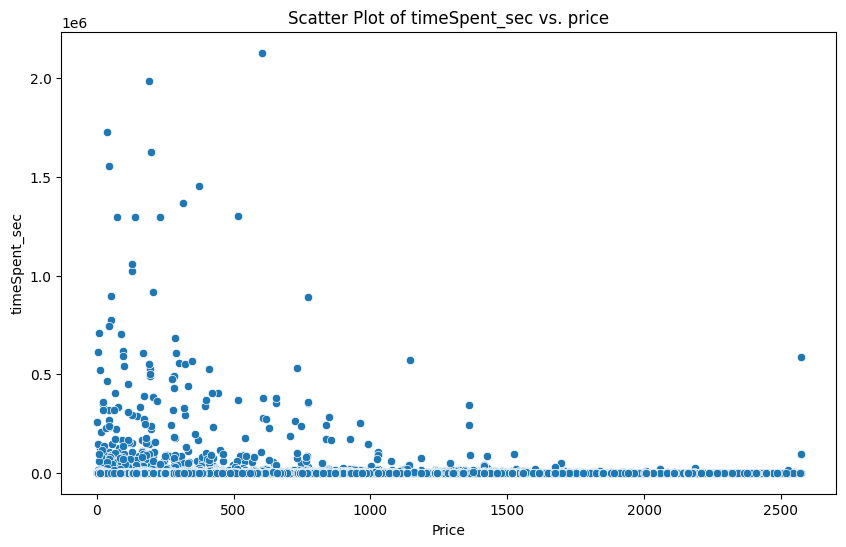

In [ ]:
scatter_data = df.select("price", "timeSpent_sec").toPandas()

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="timeSpent_sec", data=scatter_data)
plt.title("Scatter Plot of timeSpent_sec vs. price")
plt.xlabel("Price")
plt.ylabel("timeSpent_sec")
plt.show()


In [22]:
# Define categorical columns
categorical_columns = ['category_code', 'user_session']

# Create StringIndexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in categorical_columns]

# Feature columns which will support the prediction
feature_columns = ["timeSpent_sec", "price", "product_id", 'eventDay', 'count_view', 'multiChoice', 'PurBefore'] + [f"{col}_indexed" for col in categorical_columns]

# Assemble features
vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define classifiers
lr = LogisticRegression(featuresCol="scaled_features", labelCol="isPurchased", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Create pipelines for each classifier
lr_pipeline = Pipeline(stages=indexers + [vectorAssembler, scaler, lr])

# Train-Valid-Test Split on df
train_data, valid_data, test_data = df.randomSplit([0.8, 0.1, 0.1], seed=42)

# Hyperparameter tuning using cross-validation
def tune_and_evaluate(pipeline, param_grid):
    evaluator = BinaryClassificationEvaluator(labelCol="isPurchased", metricName="areaUnderROC")

    # Cross-validator
    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=3)

    # Fit the model
    model = cross_val.fit(train_data)

    # Make predictions on the validation set
    valid_predictions = model.transform(valid_data)

    # Evaluate the model on the validation set
    valid_auc = evaluator.evaluate(valid_predictions)
    print(f"AUC on the Validation Set: {valid_auc:.4f}")

    # Make predictions on the test set
    test_predictions = model.transform(test_data)

    # Evaluate the model on the test set
    test_auc = evaluator.evaluate(test_predictions)
    print(f"AUC on the Test Set: {test_auc:.4f}")

    # Print the best hyperparameters
    best_model = model.bestModel
    print(f"Best RegParam: {best_model.stages[-1].getRegParam()}")  # Regularization strength: 'C' param
    print(f"Best ElasticNetParam: {best_model.stages[-1].getElasticNetParam()}")

    # Plot ROC curve
    plot_roc_curve(valid_predictions)

    # Confusion matrix and evaluation metrics
    evaluate_classification(test_predictions)

# Function to plot ROC curve
def plot_roc_curve(predictions):
    roc_df = predictions.select("isPurchased", "probability").toPandas()
    fpr, tpr, _ = roc_curve(roc_df['isPurchased'], roc_df['probability'].apply(lambda x: x[1]))

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to evaluate classification
def evaluate_classification(predictions):
    predicted_labels = np.array(predictions.select('prediction').rdd.map(lambda x: x[0]).collect())
    labels = np.array(predictions.select('isPurchased').rdd.map(lambda x: x[0]).collect())

    # Confusion matrix
    conf_matrix = confusion_matrix(labels, predicted_labels)

    # Display the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Accuracy and precision
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels)
    print("Accuracy:", accuracy)
    print("Precision:", precision)

    # Classification report
    print(classification_report(labels, predicted_labels))

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 9 artists>

Text(0.5, 0, 'Absolute Coefficient Value')

Text(0.5, 1.0, 'Logistic Regression Feature Importance')

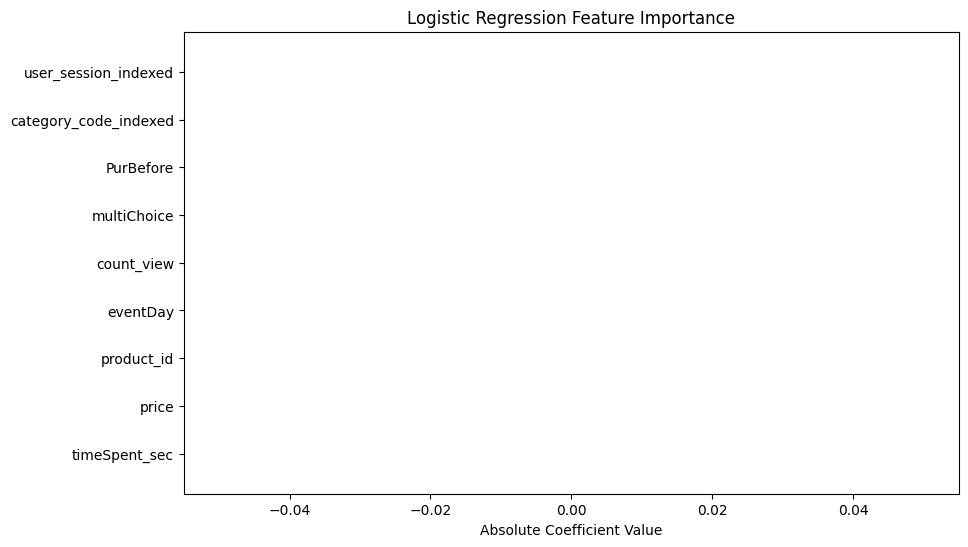

In [23]:
model_lr = lr_pipeline.fit(train_data)

# Get the coefficients from the logistic regression model
coefficients = model_lr.stages[-1].coefficients.toArray()


feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Coefficient": coefficients})

# Sort the DataFrame by absolute coefficient value in descending order
feature_importance_df["Abs_Coefficient"] = feature_importance_df["Coefficient"].abs()
feature_importance_df = feature_importance_df.sort_values(by="Abs_Coefficient", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Abs_Coefficient"])
plt.xlabel("Absolute Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.show()


AUC on the Validation Set: 0.7960
AUC on the Test Set: 0.7900
Best RegParam: 0.01
Best ElasticNetParam: 0.5


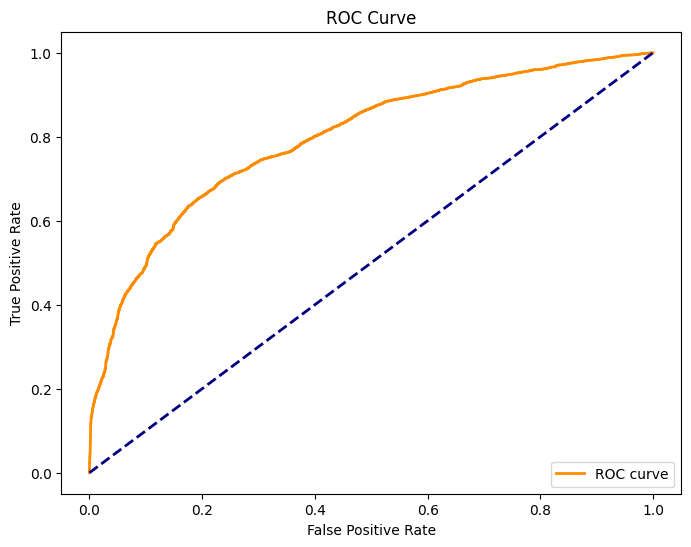

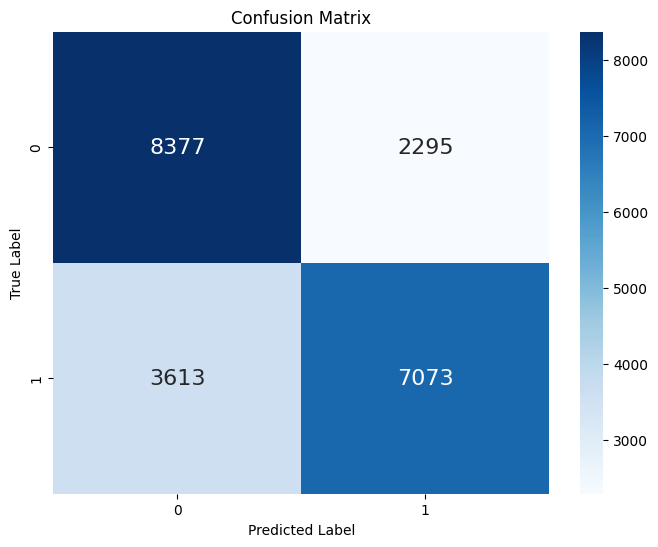

Accuracy: 0.7233823391703343
Precision: 0.7550170794192997
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     10672
           1       0.76      0.66      0.71     10686

    accuracy                           0.72     21358
   macro avg       0.73      0.72      0.72     21358
weighted avg       0.73      0.72      0.72     21358



In [24]:
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

# Call the tune_and_evaluate function with the logistic regression pipeline and hyperparameter grid
tune_and_evaluate(lr_pipeline, lr_param_grid)

AUC on the Test Set: 0.5000
Best RegParam: 0.3
Best ElasticNetParam: 0.8


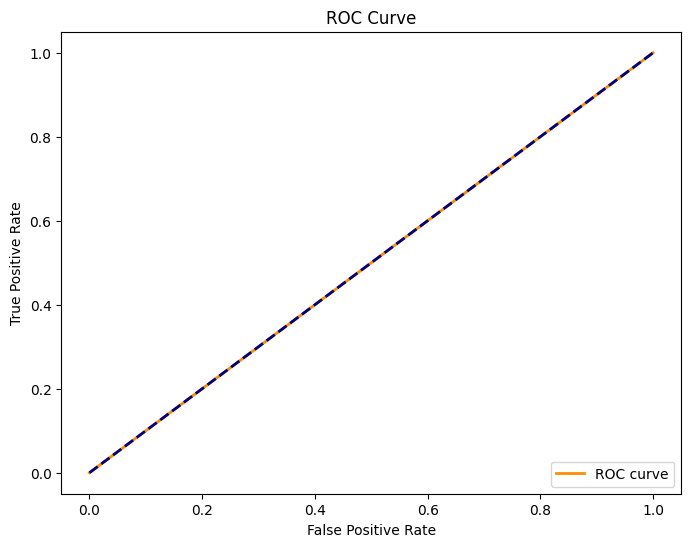

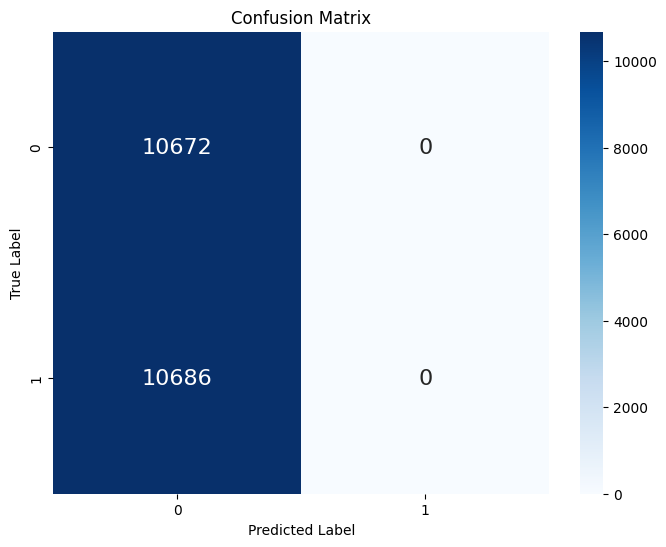

Accuracy: 0.49967225395636294
Precision: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10672
           1       0.00      0.00      0.00     10686

    accuracy                           0.50     21358
   macro avg       0.25      0.50      0.33     21358
weighted avg       0.25      0.50      0.33     21358



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

In [25]:

#To discard --trial

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Best hyperparameters obtained from hyperparameter tuning
best_reg_param = model_lr.stages[-1].getRegParam()
best_elastic_net_param = model_lr.stages[-1].getElasticNetParam()

# Define a new logistic regression model with the best hyperparameters
best_lr_model = LogisticRegression(featuresCol="scaled_features", labelCol="isPurchased",
                                   maxIter=10, regParam=best_reg_param, elasticNetParam=best_elastic_net_param)

# Create a new pipeline with the best logistic regression model
best_lr_pipeline = Pipeline(stages=indexers + [vectorAssembler, scaler, best_lr_model])

# Train the model on the entire training dataset
best_model_lr = best_lr_pipeline.fit(train_data)

# Make predictions on the test set
test_predictions = best_model_lr.transform(test_data)

# Evaluate the model on the test set
evaluator = BinaryClassificationEvaluator(labelCol="isPurchased", metricName="areaUnderROC")
test_auc = evaluator.evaluate(test_predictions)
print(f"AUC on the Test Set: {test_auc:.4f}")

# Print the best hyperparameters
print(f"Best RegParam: {best_reg_param}")  # Regularization strength: 'C' param
print(f"Best ElasticNetParam: {best_elastic_net_param}")

# Plot ROC curve
plot_roc_curve(test_predictions)

# Confusion matrix and evaluation metrics
evaluate_classification(test_predictions)
